# Data Analysis and exploration

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

In [15]:
df = pd.read_csv('avg_high_scores.csv', encoding="utf-8")
vg_df = df
vg_df = vg_df.copy()
vg_df.head()

,title,platform,release_date,score,user_score,developer,genre,critics,users,franchise
0,.hack//G.U. Last Recode,PlayStation4,3-Nov-17,76,8.1,CyberConnect2,"Miscellaneous,Compilation",21,64,hack
1,.hack//G.U. Last Recode,PC,3-Nov-17,69,8.0,CyberConnect2,"Miscellaneous,Compilation",7,25,hack
2,#IDARB,XboxOne,30-Jan-15,77,6.9,OtherOceanInteractive,"Action,General",31,88,#IDARB
3,007: Quantum of Solace,PlayStation3,4-Nov-08,65,6.6,Treyarch,"Action,General,Shooter,Shooter,First-Person,Mo...",42,59,007: Quantum of Solace
4,007: Quantum of Solace,PC,4-Nov-08,70,6.1,"Treyarch,Beenox","Action,General,Shooter,Shooter,First-Person,Mo...",18,64,007: Quantum of Solace


# Top Values in Dataset

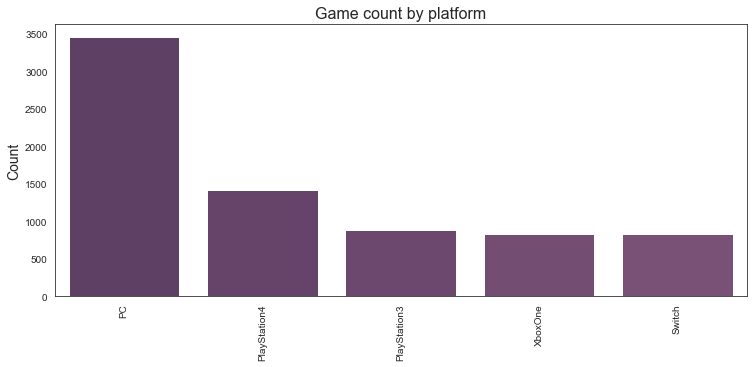

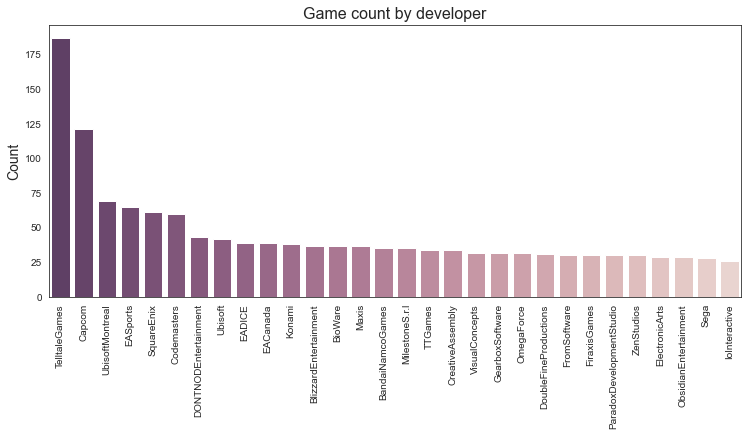

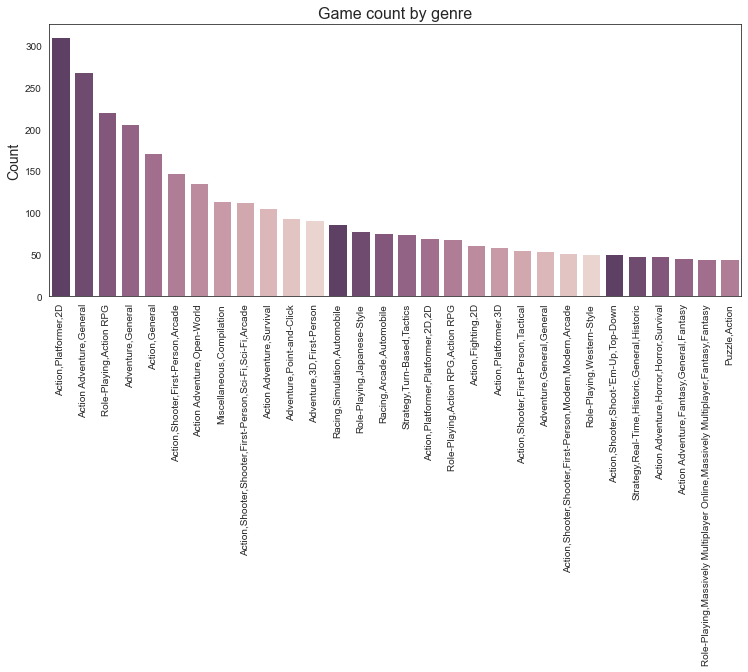

In [16]:
cols = ['platform', 'developer', 'genre']

for col in cols:
    chart = df[['title', col]].groupby([col]).count().sort_values('title', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='title', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

# Sales vs Critic Scores

In [17]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [18]:
dfh = df.dropna(subset=['score']).reset_index(drop=True)
dfh['Score_Group'] = dfh['score'].apply(lambda x: score_group(x))

In [19]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'platform':
        return 14.4
    elif x == 'developer':
        return 13.2
    elif x == 'genre':
        return 13.6

def height(x):
    if x == 'genre':
        return 8
    else:
        return 9

In [ ]:
cols = ['genre', 'developer', 'platform']
for col in cols:
    pack = []
    top = dfh[['title', col]].groupby([col]).count().sort_values('title', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, "Score_Group", "Global_Sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

# Dataset Correlations

In [21]:
cols = ['platform', 'genre', 'developer', 'score', 'user_score']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [23]:
df1 = df[['platform','genre','score']] # add release_date and global_sales column
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

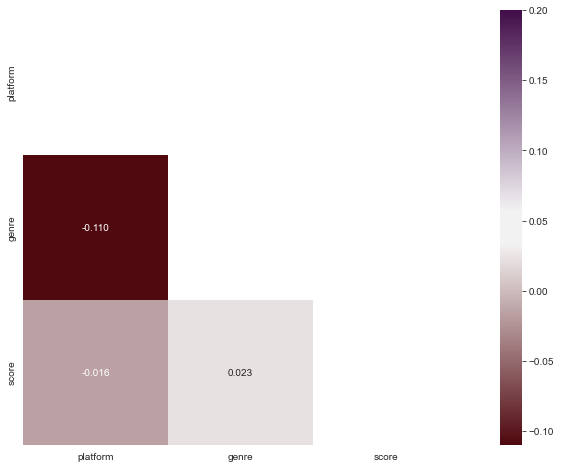

In [24]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20) # note: 680, 350/470
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

AttributeError: 'DataFrame' object has no attribute 'release_date'

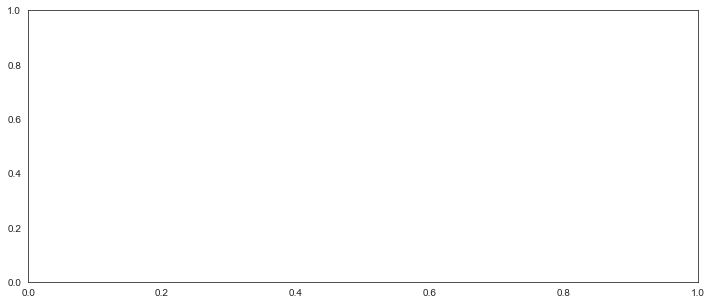

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="score", y="global_sales", data=df1.loc[df1.release_date >= 2014],
            truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

# Defining Hits

In [ ]:
dfb = dfa[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df2['Hit'] = df2['Global_Sales']
df2.drop('Global_Sales', axis=1, inplace=True)

In [ ]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

In [ ]:
# Logistic regression plot with sample of the data
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#75556c")

# Prediction Model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn import svm

In [ ]:
# Generate features
df2.head()

In [ ]:
from pandas import get_dummies
df_copy = pd.get_dummies(df2)
df_copy.head()

In [ ]:
df3 = df_copy
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50, random_state=2)

In [ ]:
radm = RandomForestClassifier(random_state=2).fit(Xtrain, ytrain)
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

In [ ]:
log_reg = LogisticRegression().fit(Xtrain, ytrain)
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == ytest)/len(ytest))

In [ ]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

In [ ]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.5, ax=ax, fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
sns.plt.title('Training Set Confusion Matrix')

In [ ]:
indices = np.argsort(radm.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking (top 10):')

for f in range(10):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df3.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

# Top Hits

In [ ]:
not_hit_copy = df_copy[df_copy['Hit'] == 0]

In [ ]:
df4 = not_hit_copy
y = df4['Hit'].values
df4 = df4.drop(['Hit'],axis=1)
X = df4.values

In [ ]:
pred = log_reg.predict_proba(X)

In [ ]:
dfb = dfb[dfb['Global_Sales'] < 1]

In [ ]:
dfb['Hit_Probability'] = pred[:,1]

In [ ]:
dfb = dfb[dfb['Year_of_Release'] == 2016]
dfb.sort_values(['Hit_Probability'], ascending=[False], inplace=True)
dfb = dfb[['Name', 'Platform', 'Hit_Probability']]

In [ ]:
dfb[:10].reset_index(drop=True)

In [ ]:
dfb[:-11:-1].reset_index(drop=True)